# Decomposoitions and Plots

In [10]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 16 12:38:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [6]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 364 (delta 23), reused 32 (delta 12), pack-reused 316 (from 1)
Receiving objects: 100% (364/364), 27.85 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (170/170), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 82.7 MB/s eta 0:00:00


In [22]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 106.6 MB/s eta 0:00:00


# Choice

In [7]:
mat_path = "choice_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    # Removed: fbins = np.array(f["fbins"])
    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [33]:
Pow_choice = Pow.T
Pos_2d_choice = ch_pos_m[:, :2]
Pow_choice.shape

(195, 121, 35, 751)

In [35]:
indices_to_remove = [0, 1]

Pow_filter_choice = np.delete(Pow_choice, indices_to_remove, axis=2)
Pow_filter_choice.shape

(195, 121, 33, 751)

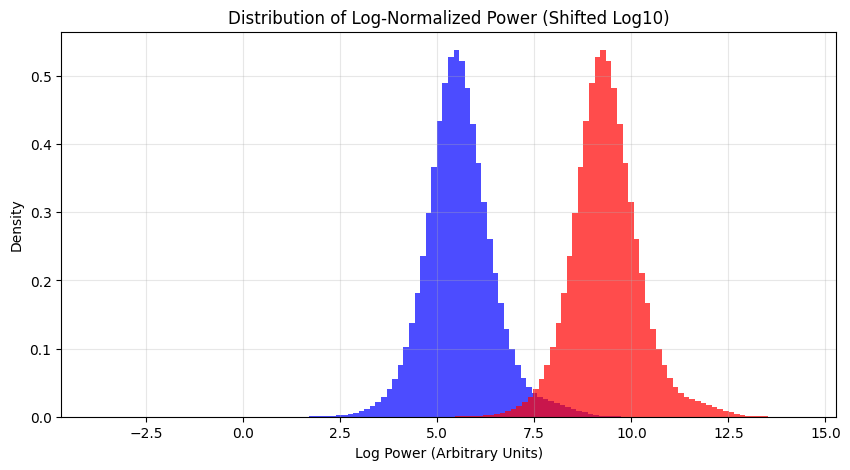

In [12]:

epsilon = 1e-20
log_Pow_choice = np.log10(Pow_choice + epsilon)

# Shift so the minimum is 0 (optional, but helpful for non-negative decomposition)
# This makes it similar to a dB scale relative to the noise floor
log_Pow_shifted_choice = log_Pow_choice - np.min(log_Pow_choice)

# 2. Plot the Distribution
plt.figure(figsize=(10, 5))
plt.hist(log_Pow_choice.ravel(), bins=100, density=True, color='blue', alpha=0.7)
plt.hist(log_Pow_shifted_choice.ravel(), bins=100, density=True, color='red', alpha=0.7)

plt.title("Distribution of Log-Normalized Power (Shifted Log10)")
plt.xlabel("Log Power (Arbitrary Units)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()



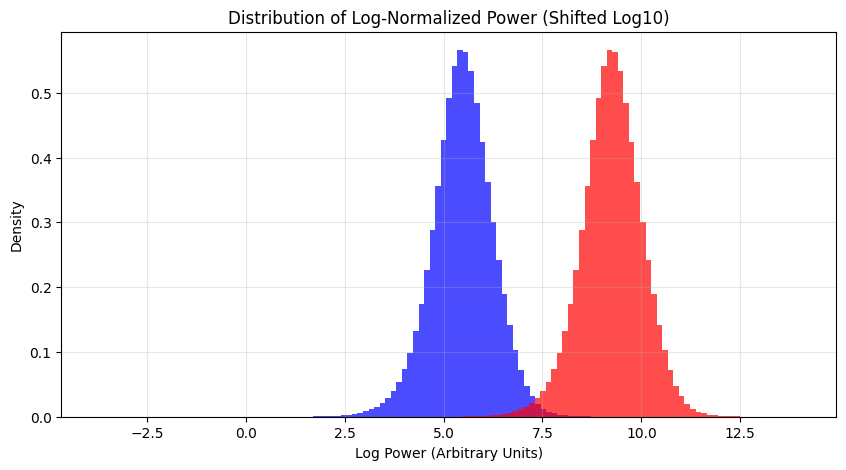

In [38]:

epsilon = 1e-20
log_Pow_filter_choice = np.log10(Pow_filter_choice + epsilon)

# Shift so the minimum is 0 (optional, but helpful for non-negative decomposition)
# This makes it similar to a dB scale relative to the noise floor
log_Pow_shifted_filter_choice = log_Pow_filter_choice - np.min(log_Pow_filter_choice)

# 2. Plot the Distribution
plt.figure(figsize=(10, 5))
plt.hist(log_Pow_filter_choice.ravel(), bins=100, density=True, color='blue', alpha=0.7)
plt.hist(log_Pow_shifted_filter_choice.ravel(), bins=100, density=True, color='red', alpha=0.7)

plt.title("Distribution of Log-Normalized Power (Shifted Log10)")
plt.xlabel("Log Power (Arbitrary Units)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()



In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_shifted_filtered_torch_choice = torch.as_tensor(log_Pow_shifted_filter_choice, device=device, dtype=torch.float32)
log_Pow_shifted_filtered_torch_choice.shape[2]

33

In [40]:
from tensorly.decomposition import non_negative_parafac_hals
import tensorly as tl
tl.set_backend('pytorch')

In [48]:
x = 12



cp_tensor_choice = non_negative_parafac_hals(
                log_Pow_shifted_filtered_torch_choice,
                rank=x,
                init="random",
                n_iter_max=2000,
                tol=1e-8,
                random_state=5  # Ensure different random init
            )

In [51]:
from tensorly.cp_tensor import cp_normalize

In [54]:
import torch
import tensorly as tl
from tensorly.cp_tensor import cp_normalize

# Ensure TensorLy is using the torch backend
tl.set_backend('pytorch')

def sort_cp_by_weight_torch(cp_tensor):
    """
    Sorts CP components in descending order using PyTorch.

    Parameters:
    -----------
    cp_tensor : tuple (weights, factors)
        Weights should be a 1D torch tensor, factors a list of 2D torch tensors.

    Returns:
    --------
    tuple : (sorted_weights, sorted_factors)
    """
    # 1. Normalise to move magnitude to weights
    # This scales factor columns to unit norm
    weights, factors = cp_normalize(cp_tensor)

    # 2. Get indices for descending order
    # torch.argsort is used here to stay within the torch backend
    indices = torch.argsort(weights, descending=True)

    # 3. Reorder weights
    sorted_weights = weights[indices]

    # 4. Reorder columns of each factor matrix
    # factors is a list of [Mode1, Mode2, ..., ModeN]
    sorted_factors = [f[:, indices] for f in factors]

    return (sorted_weights, sorted_factors)

In [56]:
cp_tensor_choice = sort_cp_by_weight_torch(cp_tensor_choice)

In [59]:
weights_choice, factors_choice = cp_tensor_choice

A_choice, B_choice, C_choice, D_choice = [f.to('cpu').numpy() for f in factors_choice]

In [31]:
%cd Tensor-Decompositions-OPM-MEG/
from src.utils.plots import plot_factors

[Errno 2] No such file or directory: 'Tensor-Decompositions-OPM-MEG/'
/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


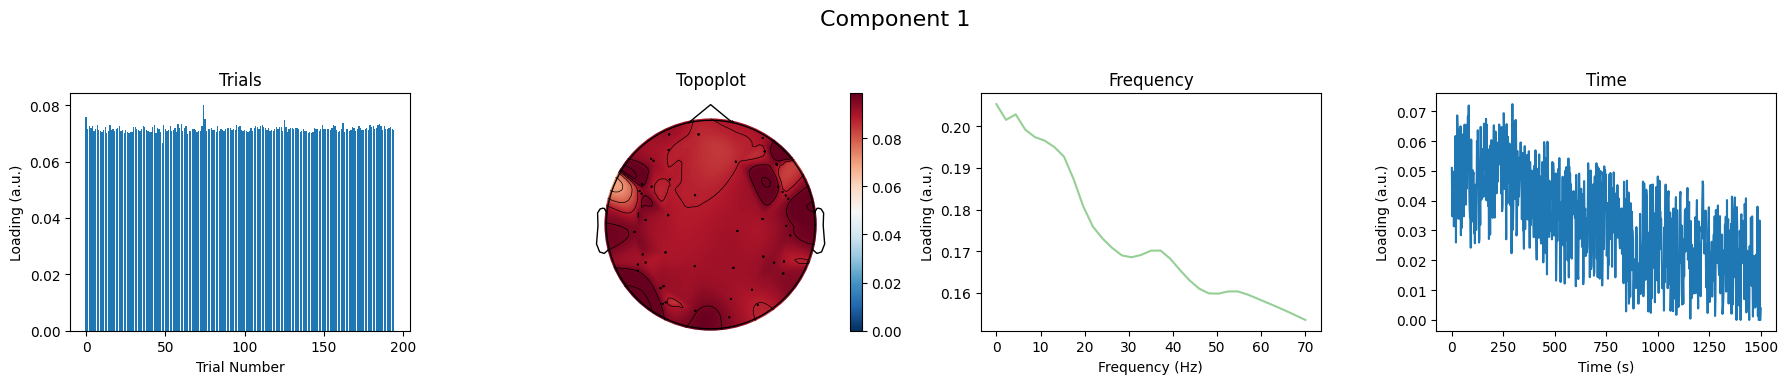

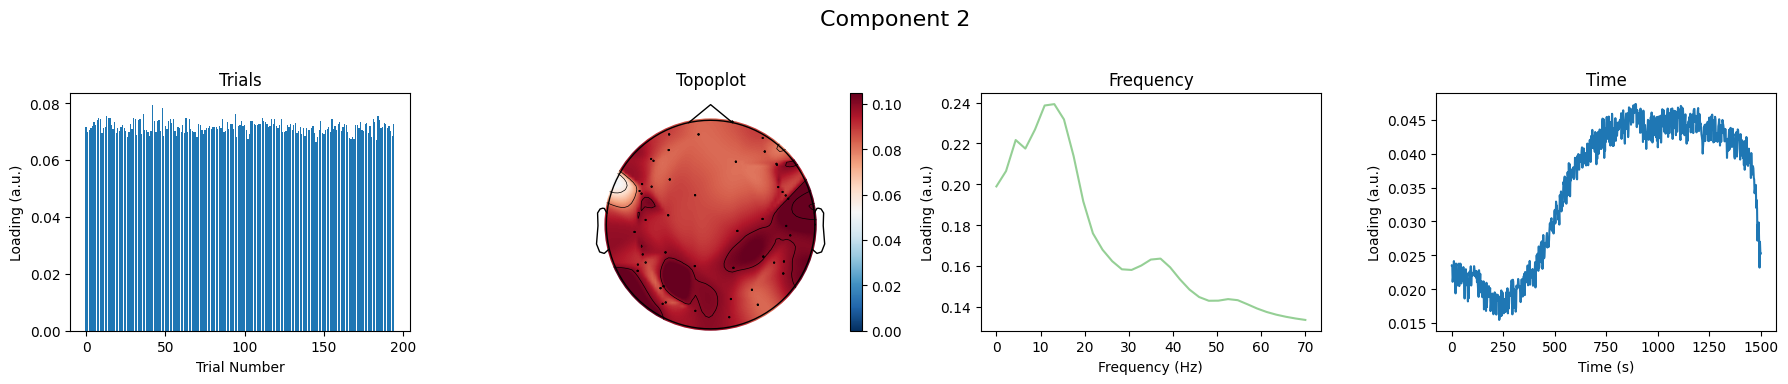

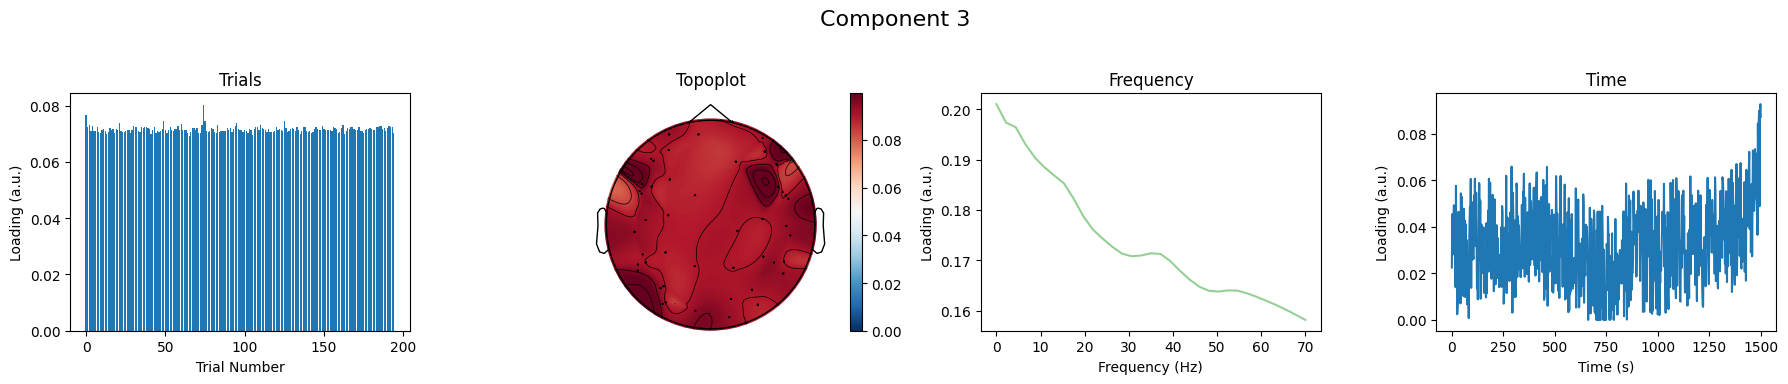

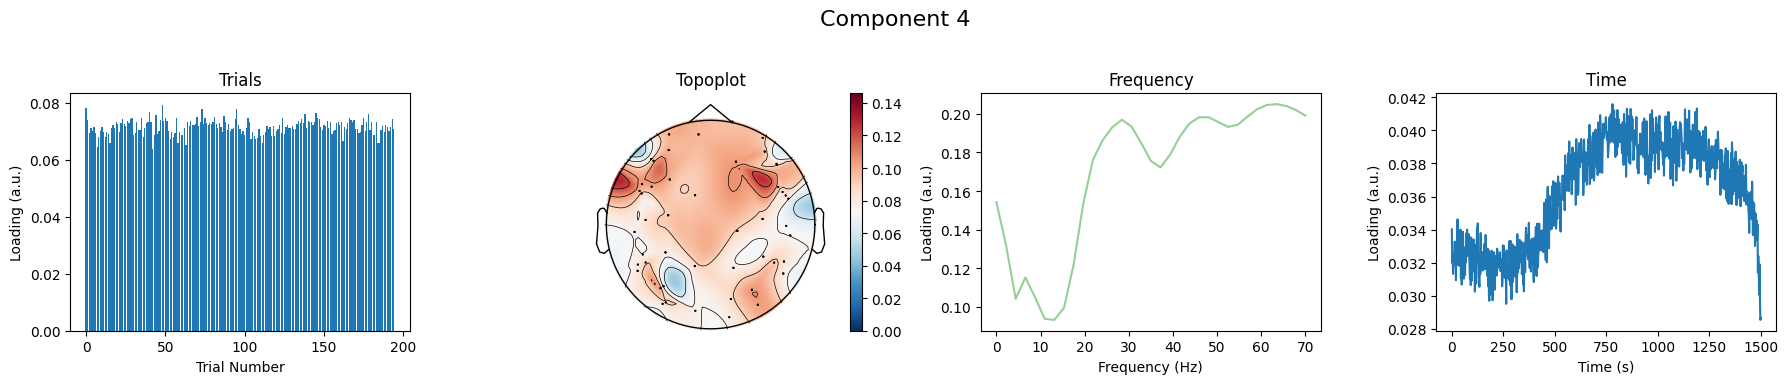

In [58]:
plot_factors(A_choice,B_choice,C_choice,D_choice,Pos_2d_choice)

# Outcome